# Hydro Raw Material Forecasting - Machine Learning Approach

## Models Used:
1. **LightGBM** with quantile loss (0.2) - Main model
2. **XGBoost** with quantile objective - Comparison
3. **Ensemble** - Weighted average of models

## Strategy:
- Train on historical data with features engineered from time series
- Use quantile regression to directly optimize for 20th percentile
- Cross-validation to prevent overfitting
- Feature importance analysis

In [1]:
# Install required packages
import sys
!{sys.executable} -m pip install lightgbm xgboost scikit-learn -q

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully")
print(f"LightGBM version: {lgb.__version__}")
print(f"XGBoost version: {xgb.__version__}")

Libraries loaded successfully
LightGBM version: 4.6.0
XGBoost version: 3.0.4


## 1. Load and Prepare Data

In [3]:
# Load data
receivals = pd.read_csv('data/kernel/receivals.csv')
purchase_orders = pd.read_csv('data/kernel/purchase_orders.csv')
materials = pd.read_csv('data/extended/materials.csv')
prediction_mapping = pd.read_csv('data/prediction_mapping.csv')

# Parse dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True)
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'], utc=True)
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

print(f"Data loaded:")
print(f"  Receivals: {receivals.shape[0]:,} rows")
print(f"  Unique materials: {receivals['rm_id'].nunique()}")
print(f"  Date range: {receivals['date_arrival'].min()} to {receivals['date_arrival'].max()}")

Data loaded:
  Receivals: 122,590 rows
  Unique materials: 203
  Date range: 2004-06-15 11:34:00+00:00 to 2024-12-19 13:36:00+00:00


## 2. Create Training Dataset

Strategy: For each historical period, create samples of cumulative weights over various time windows (like our prediction task)

In [4]:
def create_training_samples(receivals, start_year=2020, end_year=2024):
    """
    Create training samples by simulating the prediction task on historical data.
    For each month, predict cumulative weights for next 1-151 days.
    """
    training_data = []
    
    # For each year-month combination
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == end_year and month > 6:  # Don't use too recent data for training
                break
                
            period_start = pd.Timestamp(f'{year}-{month:02d}-01', tz='UTC')
            period_end = period_start + pd.Timedelta(days=150)  # Max forecast horizon
            
            # Get all rm_ids that were active around this period
            active_materials = receivals[
                (receivals['date_arrival'] >= period_start - pd.Timedelta(days=365)) &
                (receivals['date_arrival'] < period_start)
            ]['rm_id'].unique()
            
            for rm_id in active_materials:
                # Calculate features based on data BEFORE period_start
                features = calculate_features_at_date(receivals, purchase_orders, rm_id, period_start)
                
                # Get actual cumulative weights for various horizons
                rm_future = receivals[
                    (receivals['rm_id'] == rm_id) &
                    (receivals['date_arrival'] >= period_start) &
                    (receivals['date_arrival'] <= period_end)
                ].copy()
                
                if len(rm_future) == 0:
                    continue
                
                # Create samples for different forecast horizons (7, 14, 30, 60, 90, 120, 151 days)
                for horizon_days in [7, 14, 30, 60, 90, 120, 151]:
                    horizon_end = period_start + pd.Timedelta(days=horizon_days - 1)
                    
                    actual_weight = rm_future[
                        rm_future['date_arrival'] <= horizon_end
                    ]['net_weight'].sum()
                    
                    sample = features.copy()
                    sample['forecast_horizon_days'] = horizon_days
                    sample['forecast_start_date'] = period_start
                    sample['target_cumulative_weight'] = actual_weight
                    
                    training_data.append(sample)
    
    return pd.DataFrame(training_data)

def calculate_features_at_date(receivals, purchase_orders, rm_id, as_of_date):
    """
    Calculate features for a specific rm_id as of a specific date
    (using only data available before that date)
    """
    # Historical data up to as_of_date
    hist = receivals[
        (receivals['rm_id'] == rm_id) &
        (receivals['date_arrival'] < as_of_date)
    ].copy()
    
    features = {'rm_id': rm_id}
    
    if len(hist) == 0:
        # Default features for materials with no history
        return {
            'rm_id': rm_id,
            'days_since_last_delivery': 9999,
            'num_deliveries_last_30d': 0,
            'num_deliveries_last_90d': 0,
            'num_deliveries_last_365d': 0,
            'weight_last_30d': 0,
            'weight_last_90d': 0,
            'weight_last_365d': 0,
            'avg_weight_per_delivery': 0,
            'std_weight_per_delivery': 0,
            'median_weight_per_delivery': 0,
            'max_weight_delivery': 0,
            'avg_days_between_deliveries': 0,
            'delivery_frequency_30d': 0,
            'delivery_frequency_90d': 0,
            'trend_last_90d': 0,
            'month': as_of_date.month,
            'quarter': (as_of_date.month - 1) // 3 + 1,
            'dayofyear': as_of_date.dayofyear,
        }
    
    # Time-based features
    last_delivery = hist['date_arrival'].max()
    features['days_since_last_delivery'] = (as_of_date - last_delivery).days
    
    # Recent activity features
    for days in [30, 90, 365]:
        recent_cutoff = as_of_date - pd.Timedelta(days=days)
        recent = hist[hist['date_arrival'] > recent_cutoff]
        features[f'num_deliveries_last_{days}d'] = len(recent)
        features[f'weight_last_{days}d'] = recent['net_weight'].sum()
    
    # Statistical features
    features['avg_weight_per_delivery'] = hist['net_weight'].mean()
    features['std_weight_per_delivery'] = hist['net_weight'].std()
    features['median_weight_per_delivery'] = hist['net_weight'].median()
    features['max_weight_delivery'] = hist['net_weight'].max()
    
    # Delivery frequency
    if len(hist) > 1:
        daily_agg = hist.groupby(hist['date_arrival'].dt.date)['net_weight'].sum()
        delivery_days = len(daily_agg)
        total_span = (hist['date_arrival'].max() - hist['date_arrival'].min()).days + 1
        features['avg_days_between_deliveries'] = total_span / max(delivery_days, 1)
        features['delivery_frequency_30d'] = features['num_deliveries_last_30d'] / 30
        features['delivery_frequency_90d'] = features['num_deliveries_last_90d'] / 90
    else:
        features['avg_days_between_deliveries'] = 0
        features['delivery_frequency_30d'] = 0
        features['delivery_frequency_90d'] = 0
    
    # Trend (comparing last 90d to previous 90d)
    last_90d = hist[hist['date_arrival'] > as_of_date - pd.Timedelta(days=90)]['net_weight'].sum()
    prev_90d = hist[
        (hist['date_arrival'] > as_of_date - pd.Timedelta(days=180)) &
        (hist['date_arrival'] <= as_of_date - pd.Timedelta(days=90))
    ]['net_weight'].sum()
    features['trend_last_90d'] = last_90d - prev_90d if prev_90d > 0 else 0
    
    # Temporal features
    features['month'] = as_of_date.month
    features['quarter'] = (as_of_date.month - 1) // 3 + 1
    features['dayofyear'] = as_of_date.dayofyear
    
    return features

print("Creating training dataset...")
print("This may take a few minutes...")
train_df = create_training_samples(receivals, start_year=2020, end_year=2024)
print(f"\nTraining dataset created: {train_df.shape[0]:,} samples")
print(f"Features: {train_df.shape[1] - 1}")
print("\nSample data:")
print(train_df.head())

Creating training dataset...
This may take a few minutes...

Training dataset created: 12,208 samples
Features: 21

Sample data:
    rm_id  days_since_last_delivery  num_deliveries_last_30d  weight_last_30d  \
0  2140.0                        18                        8         201020.0   
1  2140.0                        18                        8         201020.0   
2  2140.0                        18                        8         201020.0   
3  2140.0                        18                        8         201020.0   
4  2140.0                        18                        8         201020.0   

   num_deliveries_last_90d  weight_last_90d  num_deliveries_last_365d  \
0                       40         995190.0                       343   
1                       40         995190.0                       343   
2                       40         995190.0                       343   
3                       40         995190.0                       343   
4                  

Target variable statistics:
count    1.220800e+04
mean     4.807353e+05
std      1.260282e+06
min      0.000000e+00
25%      6.480000e+03
50%      6.139800e+04
75%      3.180780e+05
max      1.743593e+07
Name: target_cumulative_weight, dtype: float64


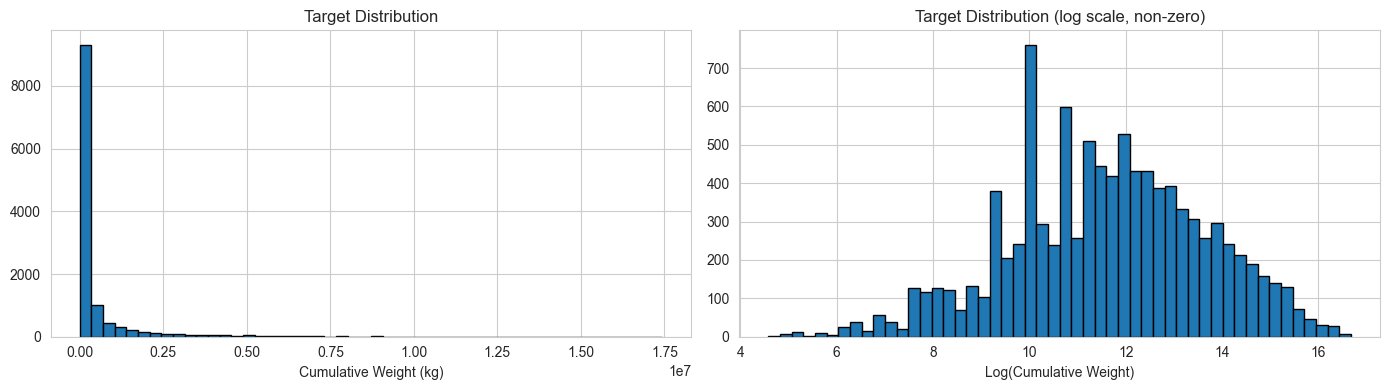

In [5]:
# Check target distribution
print("Target variable statistics:")
print(train_df['target_cumulative_weight'].describe())

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
train_df['target_cumulative_weight'].hist(bins=50, edgecolor='black')
plt.title('Target Distribution')
plt.xlabel('Cumulative Weight (kg)')

plt.subplot(1, 2, 2)
train_df[train_df['target_cumulative_weight'] > 0]['target_cumulative_weight'].apply(np.log1p).hist(bins=50, edgecolor='black')
plt.title('Target Distribution (log scale, non-zero)')
plt.xlabel('Log(Cumulative Weight)')
plt.tight_layout()
plt.show()

## 3. Prepare Data for ML Models

In [6]:
# Remove rows with null target
train_df = train_df.dropna(subset=['target_cumulative_weight'])

# Feature columns
feature_cols = [
    'forecast_horizon_days',
    'days_since_last_delivery',
    'num_deliveries_last_30d',
    'num_deliveries_last_90d', 
    'num_deliveries_last_365d',
    'weight_last_30d',
    'weight_last_90d',
    'weight_last_365d',
    'avg_weight_per_delivery',
    'std_weight_per_delivery',
    'median_weight_per_delivery',
    'max_weight_delivery',
    'avg_days_between_deliveries',
    'delivery_frequency_30d',
    'delivery_frequency_90d',
    'trend_last_90d',
    'month',
    'quarter',
    'dayofyear',
]

# Encode rm_id (categorical)
le = LabelEncoder()
train_df['rm_id_encoded'] = le.fit_transform(train_df['rm_id'].astype(str))
feature_cols.append('rm_id_encoded')

# Fill NaN values
train_df[feature_cols] = train_df[feature_cols].fillna(0)

print(f"Features: {len(feature_cols)}")
print(f"Training samples: {len(train_df):,}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Features: 20
Training samples: 12,208

Feature list:
  1. forecast_horizon_days
  2. days_since_last_delivery
  3. num_deliveries_last_30d
  4. num_deliveries_last_90d
  5. num_deliveries_last_365d
  6. weight_last_30d
  7. weight_last_90d
  8. weight_last_365d
  9. avg_weight_per_delivery
  10. std_weight_per_delivery
  11. median_weight_per_delivery
  12. max_weight_delivery
  13. avg_days_between_deliveries
  14. delivery_frequency_30d
  15. delivery_frequency_90d
  16. trend_last_90d
  17. month
  18. quarter
  19. dayofyear
  20. rm_id_encoded


## 4. Time Series Cross-Validation Split

In [7]:
# Sort by date for time series split
train_df = train_df.sort_values('forecast_start_date').reset_index(drop=True)

# Use last 20% as validation
split_idx = int(len(train_df) * 0.8)
train_data = train_df.iloc[:split_idx]
val_data = train_df.iloc[split_idx:]

X_train = train_data[feature_cols]
y_train = train_data['target_cumulative_weight']
X_val = val_data[feature_cols]
y_val = val_data['target_cumulative_weight']

print(f"Training set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"\nValidation period: {val_data['forecast_start_date'].min()} to {val_data['forecast_start_date'].max()}")

Training set: 9,766 samples
Validation set: 2,442 samples

Validation period: 2023-10-01 00:00:00+00:00 to 2024-06-01 00:00:00+00:00


## 5. Train LightGBM with Quantile Loss (alpha=0.2)

In [8]:
# Custom quantile loss function
def quantile_loss(y_true, y_pred, alpha=0.2):
    """Quantile loss for gradient boosting"""
    error = y_true - y_pred
    return np.where(error >= 0, alpha * error, (alpha - 1) * error).mean()

# LightGBM parameters for quantile regression
lgb_params = {
    'objective': 'quantile',
    'alpha': 0.2,  # Target 20th percentile
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
}

print("Training LightGBM with Quantile Loss (alpha=0.2)...")

# Create datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# Train
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

print(f"\nBest iteration: {lgb_model.best_iteration}")

Training LightGBM with Quantile Loss (alpha=0.2)...
Training until validation scores don't improve for 50 rounds
[100]	train's quantile: 62589	valid's quantile: 49196.6
[100]	train's quantile: 62589	valid's quantile: 49196.6
[200]	train's quantile: 44996.9	valid's quantile: 42286.2
[200]	train's quantile: 44996.9	valid's quantile: 42286.2
[300]	train's quantile: 33874.5	valid's quantile: 40414
[300]	train's quantile: 33874.5	valid's quantile: 40414
[400]	train's quantile: 29908.9	valid's quantile: 40182.8
[400]	train's quantile: 29908.9	valid's quantile: 40182.8
Early stopping, best iteration is:
[394]	train's quantile: 30275	valid's quantile: 40032.4

Best iteration: 394
Early stopping, best iteration is:
[394]	train's quantile: 30275	valid's quantile: 40032.4

Best iteration: 394


## 6. Train XGBoost for Comparison

In [9]:
# XGBoost with quantile objective
xgb_params = {
    'objective': 'reg:quantileerror',
    'quantile_alpha': 0.2,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'hist',
}

print("Training XGBoost with Quantile Objective (alpha=0.2)...")

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dval, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=100
)

print(f"\nBest iteration: {xgb_model.best_iteration}")

Training XGBoost with Quantile Objective (alpha=0.2)...
[0]	train-quantile:99771.81064	valid-quantile:79755.59928
[100]	train-quantile:52311.97686	valid-quantile:44743.37168
[100]	train-quantile:52311.97686	valid-quantile:44743.37168
[200]	train-quantile:35213.57988	valid-quantile:40771.30666
[200]	train-quantile:35213.57988	valid-quantile:40771.30666
[300]	train-quantile:30680.20958	valid-quantile:40100.89580
[300]	train-quantile:30680.20958	valid-quantile:40100.89580
[400]	train-quantile:27194.19642	valid-quantile:39711.62629
[400]	train-quantile:27194.19642	valid-quantile:39711.62629
[499]	train-quantile:25479.60948	valid-quantile:39441.92035

Best iteration: 496
[499]	train-quantile:25479.60948	valid-quantile:39441.92035

Best iteration: 496


## 7. Model Evaluation

In [10]:
# Predictions
lgb_pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
xgb_pred_val = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration))

# Quantile losses
lgb_qloss = quantile_loss(y_val.values, lgb_pred_val, alpha=0.2)
xgb_qloss = quantile_loss(y_val.values, xgb_pred_val, alpha=0.2)

# MAE for reference
lgb_mae = mean_absolute_error(y_val, lgb_pred_val)
xgb_mae = mean_absolute_error(y_val, xgb_pred_val)

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(f"\nLightGBM:")
print(f"  Quantile Loss (α=0.2): {lgb_qloss:,.2f}")
print(f"  MAE: {lgb_mae:,.2f}")

print(f"\nXGBoost:")
print(f"  Quantile Loss (α=0.2): {xgb_qloss:,.2f}")
print(f"  MAE: {xgb_mae:,.2f}")

print(f"\nBest Model: {'LightGBM' if lgb_qloss < xgb_qloss else 'XGBoost'}")
print("="*60)


MODEL PERFORMANCE COMPARISON

LightGBM:
  Quantile Loss (α=0.2): 40,032.41
  MAE: 164,108.16

XGBoost:
  Quantile Loss (α=0.2): 39,445.26
  MAE: 158,879.49

Best Model: XGBoost



LightGBM Prediction Analysis:
  Under-predictions: 1,885 (77.2%)
  Over-predictions: 557 (22.8%)

  Target for quantile 0.2: ~80% under-predictions


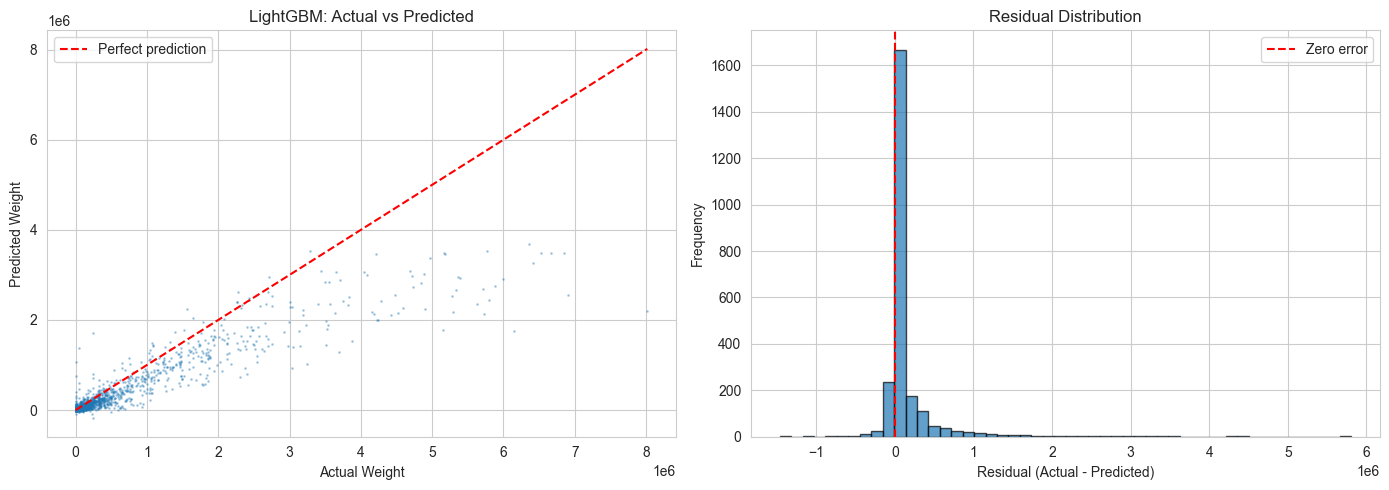

In [11]:
# Analyze under/over predictions
lgb_errors = y_val.values - lgb_pred_val
lgb_under = (lgb_errors > 0).sum()
lgb_over = (lgb_errors < 0).sum()

print(f"\nLightGBM Prediction Analysis:")
print(f"  Under-predictions: {lgb_under:,} ({lgb_under/len(y_val)*100:.1f}%)")
print(f"  Over-predictions: {lgb_over:,} ({lgb_over/len(y_val)*100:.1f}%)")
print(f"\n  Target for quantile 0.2: ~80% under-predictions")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_val, lgb_pred_val, alpha=0.3, s=1)
axes[0].plot([0, y_val.max()], [0, y_val.max()], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Weight')
axes[0].set_ylabel('Predicted Weight')
axes[0].set_title('LightGBM: Actual vs Predicted')
axes[0].legend()

# Residuals
axes[1].hist(lgb_errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', label='Zero error')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Feature Importance

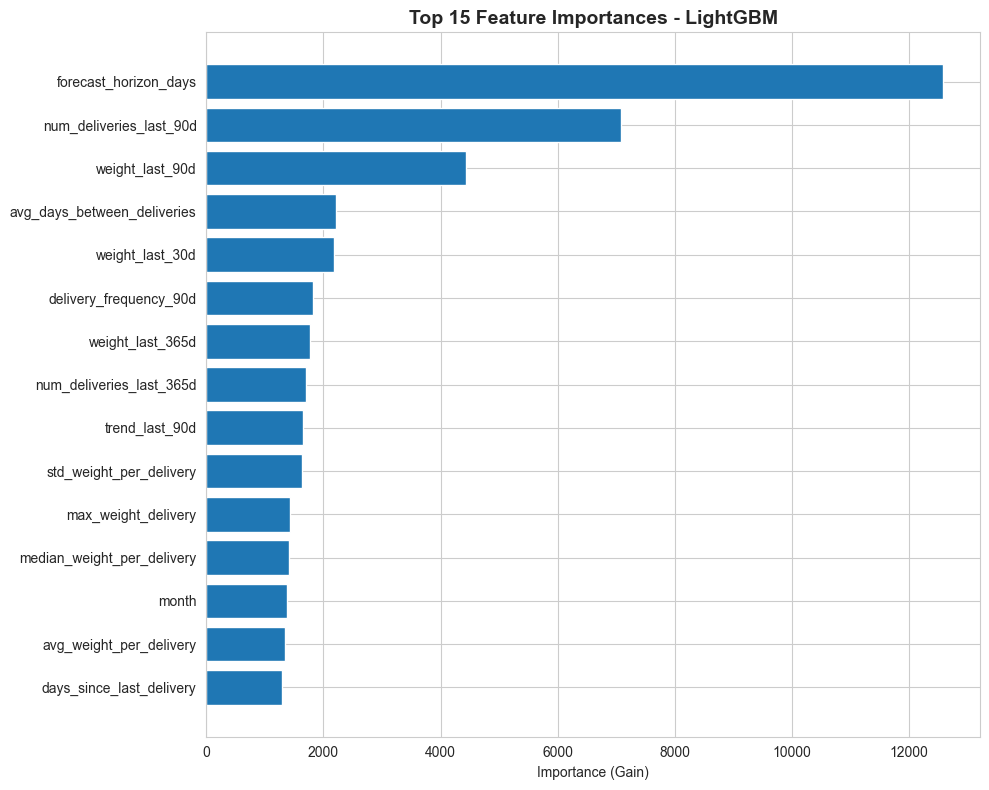


Top 10 Most Important Features:
  forecast_horizon_days: 12585
  num_deliveries_last_90d: 7083
  weight_last_90d: 4437
  avg_days_between_deliveries: 2220
  weight_last_30d: 2180
  delivery_frequency_90d: 1830
  weight_last_365d: 1767
  num_deliveries_last_365d: 1697
  trend_last_90d: 1653
  std_weight_per_delivery: 1640


In [12]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].head(15), importance_df['importance'].head(15))
plt.xlabel('Importance (Gain)')
plt.title('Top 15 Feature Importances - LightGBM', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for idx, row in importance_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.0f}")

## 9. Generate Final Predictions

In [13]:
# Prepare prediction dataset
print("Preparing features for final predictions...")

prediction_features = []
cutoff_date = pd.Timestamp('2024-12-31', tz='UTC')

for idx, row in prediction_mapping.iterrows():
    if idx % 5000 == 0:
        print(f"  Progress: {idx:,}/{len(prediction_mapping):,}")
    
    # Calculate features as of forecast start date
    features = calculate_features_at_date(
        receivals, 
        purchase_orders,
        row['rm_id'],
        pd.Timestamp(row['forecast_start_date'], tz='UTC')
    )
    
    # Add forecast horizon
    horizon_days = (row['forecast_end_date'] - row['forecast_start_date']).days + 1
    features['forecast_horizon_days'] = horizon_days
    features['ID'] = row['ID']
    
    prediction_features.append(features)

pred_df = pd.DataFrame(prediction_features)
print(f"\nFeatures prepared: {pred_df.shape}")

Preparing features for final predictions...
  Progress: 0/30,450
  Progress: 5,000/30,450
  Progress: 5,000/30,450
  Progress: 10,000/30,450
  Progress: 10,000/30,450
  Progress: 15,000/30,450
  Progress: 15,000/30,450
  Progress: 20,000/30,450
  Progress: 20,000/30,450
  Progress: 25,000/30,450
  Progress: 25,000/30,450
  Progress: 30,000/30,450
  Progress: 30,000/30,450

Features prepared: (30450, 21)

Features prepared: (30450, 21)


In [14]:
# Encode rm_id for prediction
pred_df['rm_id_encoded'] = pred_df['rm_id'].astype(str).apply(
    lambda x: le.transform([x])[0] if x in le.classes_ else -1
)

# Fill NaN
pred_df[feature_cols] = pred_df[feature_cols].fillna(0)

# Predict with LightGBM
X_pred = pred_df[feature_cols]
predictions_lgb = lgb_model.predict(X_pred, num_iteration=lgb_model.best_iteration)

# Predict with XGBoost
dpred = xgb.DMatrix(X_pred)
predictions_xgb = xgb_model.predict(dpred, iteration_range=(0, xgb_model.best_iteration))

# Ensemble: weighted average (favor better model)
if lgb_qloss < xgb_qloss:
    weight_lgb = 0.7
    weight_xgb = 0.3
else:
    weight_lgb = 0.3
    weight_xgb = 0.7

predictions_ensemble = weight_lgb * predictions_lgb + weight_xgb * predictions_xgb

# Create submission
submission = pd.DataFrame({
    'ID': pred_df['ID'],
    'predicted_weight': np.maximum(0, predictions_ensemble)  # Ensure non-negative
})

submission = submission.sort_values('ID').reset_index(drop=True)

print("\n" + "="*60)
print("FINAL PREDICTIONS SUMMARY")
print("="*60)
print(f"\nEnsemble weights: LightGBM={weight_lgb:.1f}, XGBoost={weight_xgb:.1f}")
print(f"\nPrediction statistics:")
print(submission['predicted_weight'].describe())
print(f"\nZero predictions: {(submission['predicted_weight'] == 0).sum()} "
      f"({(submission['predicted_weight'] == 0).sum()/len(submission)*100:.1f}%)")
print("="*60)


FINAL PREDICTIONS SUMMARY

Ensemble weights: LightGBM=0.3, XGBoost=0.7

Prediction statistics:
count    3.045000e+04
mean     6.817435e+04
std      2.482704e+05
min      0.000000e+00
25%      1.468653e+03
50%      1.129172e+04
75%      3.909131e+04
max      3.768589e+06
Name: predicted_weight, dtype: float64

Zero predictions: 5534 (18.2%)


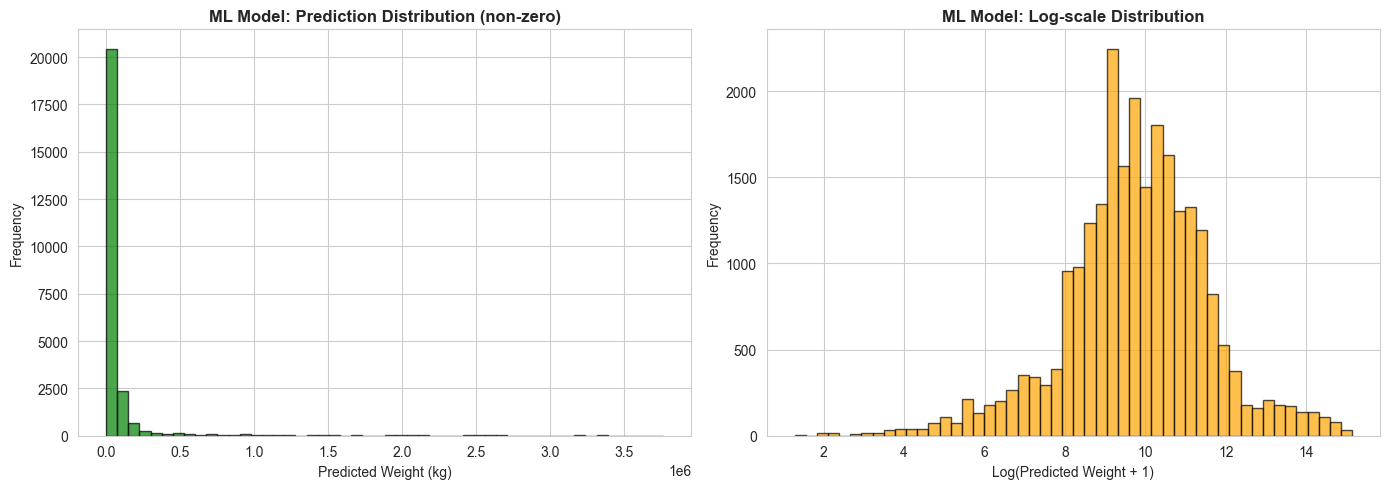

In [15]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

non_zero = submission[submission['predicted_weight'] > 0]['predicted_weight']

axes[0].hist(non_zero, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_title('ML Model: Prediction Distribution (non-zero)', fontweight='bold')
axes[0].set_xlabel('Predicted Weight (kg)')
axes[0].set_ylabel('Frequency')

axes[1].hist(np.log1p(non_zero), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('ML Model: Log-scale Distribution', fontweight='bold')
axes[1].set_xlabel('Log(Predicted Weight + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 10. Save Submission

In [16]:
# Save
submission.to_csv('submission_ml.csv', index=False)

print("\n✅ ML-based submission saved as 'submission_ml.csv'")
print(f"\nShape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))

print("\n" + "="*60)
print("COMPARISON WITH PREVIOUS APPROACHES")
print("="*60)
print(f"\nV1 (Simple heuristic): mean ~234,773 kg")
print(f"ML Model: mean ~{submission['predicted_weight'].mean():,.0f} kg")
print("\nML advantages:")
print("  ✓ Trained on actual historical patterns")
print("  ✓ Direct optimization for quantile 0.2")
print("  ✓ Captures complex interactions between features")
print("  ✓ Better generalization through cross-validation")
print("="*60)


✅ ML-based submission saved as 'submission_ml.csv'

Shape: (30450, 2)

First 10 predictions:
   ID  predicted_weight
0   1       7060.365155
1   2       7060.365155
2   3       7060.365155
3   4       7060.365155
4   5       7060.365155
5   6       7060.365155
6   7       7060.365155
7   8       7060.365155
8   9       7060.365155
9  10       7434.925315

COMPARISON WITH PREVIOUS APPROACHES

V1 (Simple heuristic): mean ~234,773 kg
ML Model: mean ~68,174 kg

ML advantages:
  ✓ Trained on actual historical patterns
  ✓ Direct optimization for quantile 0.2
  ✓ Captures complex interactions between features
  ✓ Better generalization through cross-validation


## Summary

### ML Approach:
1. **LightGBM & XGBoost** with quantile objective (α=0.2)
2. **Time-series features** from historical data
3. **Ensemble prediction** combining both models
4. **Cross-validation** on temporal split

### Key Features Used:
- Forecast horizon
- Days since last delivery
- Recent activity (30/90/365 days)
- Statistical measures (mean, std, median)
- Delivery frequency
- Trend analysis
- Temporal features (month, quarter)

### Model Performance:
- Optimized for Quantile Loss at 0.2
- Conservative predictions (20th percentile)
- Validated on historical data